In [1]:
import os
from downloader import download_file

import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

from sklearn.cluster import KMeans

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/PUIdata".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /nfshome/pmb434/PUIdata


# Find clusters of Zipcodes with highest job density to define CBDs

In [3]:
lodes_zipcode_csv = 'nyc_jobs_by_zipcode.csv'
nyc_lodes_zip = pd.read_csv(puidata + '/' + lodes_zipcode_csv)
nyc_lodes_zip.head()

,ZIP,2010_main,2010_aux,2010_total,2011_main,2011_aux,2011_total,2012_main,2012_aux,2012_total,2013_main,2013_aux,2013_total,2014_main,2014_aux,2014_total,2015_main,2015_aux,2015_total
0,10001,110844.034347,19581.224930,130425.259277,119934.398116,23090.888002,143025.286117,125107.527841,25479.839613,150587.367454,130289.410633,25957.475047,156246.885680,141243.473574,27495.652957,168739.126530,139210.585312,25517.325040,164727.910353
1,10002,17501.189156,1315.914654,18817.103810,18241.376674,1509.372059,19750.748733,18575.186672,1630.603800,20205.790472,17311.940049,1721.605455,19033.545504,19097.528421,1921.498079,21019.026500,21439.070402,1863.979643,23303.050046
2,10003,61530.840315,9363.819239,70894.659554,64739.789084,10308.860475,75048.649559,59786.418308,10273.453187,70059.871496,62081.330388,10712.407074,72793.737462,64501.109568,11508.768508,76009.878076,69158.840084,11036.073600,80194.913684
3,10004,29653.820952,7383.809509,37037.630460,31956.568737,7831.348067,39787.916803,34086.517676,8482.183181,42568.700857,32776.487794,8014.649468,40791.137261,38354.697164,8961.738961,47316.436125,40094.595260,8584.264357,48678.859617
4,10005,44953.776763,12602.323590,57556.100352,43606.040890,12769.476561,56375.517451,43311.874140,12738.632010,56050.506150,39880.206253,12228.742810,52108.949063,39087.680497,11178.336790,50266.017287,39821.496535,9739.560536,49561.057071


In [4]:
nyc_zipcode_files = download_file('https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip',
                                      'ZIP_CODE_040114.zip',
                                      puidata)
nyc_zipcode_shp = gpd.read_file(nyc_zipcode_files[1])
nyc_zipcode_shp.head()

File already downloaded.
File already extracted.
ZIP_CODE_040114.zip contents in place, you can continue.


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [5]:
#ZIPCODE as int
nyc_zipcode_shp.ZIPCODE = nyc_zipcode_shp.ZIPCODE.astype(int)

In [6]:
#Eliminate holes in Zip codes that contain other small zipcodes (buildings)
nyc_zipcode_shp.geometry = nyc_zipcode_shp.geometry.apply(lambda x: shapely.geometry.Polygon(x.exterior))

In [7]:
#Get rid of the islands
nyc_zipcode_shp = nyc_zipcode_shp.drop([109, 113, 114])

In [8]:
#Have one row per zipcode (before it was one row per polygon)
nyc_zipcode_shp = nyc_zipcode_shp.dissolve(by='ZIPCODE', as_index=False)

In [9]:
#join with data
nyc_lodes_zipcode_shp = nyc_zipcode_shp.merge(nyc_lodes_zip,
                                          right_on='ZIP',
                                          left_on='ZIPCODE',
                                          how='outer')
nyc_lodes_zipcode_shp.head()

,ZIPCODE,geometry,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,...,2012_total,2013_main,2013_aux,2013_total,2014_main,2014_aux,2014_total,2015_main,2015_aux,2015_total
0,83.0,"POLYGON ((998309.7254775614 229616.6812362969,...",0,Central Park,25.0,3.830099e+07,NY,New York,36,061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001.0,"POLYGON ((981958.6472873986 213464.4530421346,...",0,New York,22413.0,1.779494e+07,NY,New York,36,061,...,150587.367454,130289.410633,25957.475047,156246.885680,141243.473574,27495.652957,168739.126530,139210.585312,25517.325040,164727.910353
2,10002.0,"POLYGON ((991339.8703228086 207576.7837151289,...",0,New York,81305.0,2.628013e+07,NY,New York,36,061,...,20205.790472,17311.940049,1721.605455,19033.545504,19097.528421,1921.498079,21019.026500,21439.070402,1863.979643,23303.050046
3,10003.0,"POLYGON ((989830.469142139 207048.1263078749, ...",0,New York,55878.0,1.553838e+07,NY,New York,36,061,...,70059.871496,62081.330388,10712.407074,72793.737462,64501.109568,11508.768508,76009.878076,69158.840084,11036.073600,80194.913684
4,10004.0,"POLYGON ((981197.408652395 196571.0816452205, ...",0,New York,2187.0,4.002521e+06,NY,New York,36,061,...,42568.700857,32776.487794,8014.649468,40791.137261,38354.697164,8961.738961,47316.436125,40094.595260,8584.264357,48678.859617


In [10]:
#separate building zipcodes and figure out its 'parent zipcode'
nyc_lodes_zipcode_bldgs = nyc_lodes_zipcode_shp.loc[(nyc_lodes_zipcode_shp.BLDGZIP=='1'),:]
nyc_lodes_zipcode_real = nyc_lodes_zipcode_shp.loc[(nyc_lodes_zipcode_shp.BLDGZIP=='0'),:]

nyc_lodes_zipcode_bldgs['Parent ZIPCODE'] = np.nan

for i, bldg in nyc_lodes_zipcode_bldgs.iterrows():
    for j, zipcode in nyc_lodes_zipcode_real.iterrows():
        if bldg.geometry.within(zipcode.geometry):
            nyc_lodes_zipcode_bldgs.at[i, 'Parent ZIPCODE'] = zipcode.ZIPCODE

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#make parent zipcode as zipcode and append
nyc_lodes_zipcode_bldgs.ZIPCODE = nyc_lodes_zipcode_bldgs['Parent ZIPCODE']
nyc_lodes_zipcode_bldgs.drop('Parent ZIPCODE', axis=1, inplace=True)

nyc_lodes_zipcode_real = nyc_lodes_zipcode_real.append(nyc_lodes_zipcode_bldgs, ignore_index=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [12]:
#Manually fixing additional buildings not marked as buildings in the data
manual_fixes = {10115: 10027, 10111: 10020}

nyc_lodes_zipcode_real['ZIPCODE'] = nyc_lodes_zipcode_real.ZIPCODE.replace(manual_fixes)

In [13]:
#How to aggregate columns
columns_agg = {key:'sum' for key in list(nyc_lodes_zipcode_real.columns)[-18:]}
columns_agg['COUNTY'] = 'first'
columns_agg

{'2010_aux': 'sum',
 '2010_main': 'sum',
 '2010_total': 'sum',
 '2011_aux': 'sum',
 '2011_main': 'sum',
 '2011_total': 'sum',
 '2012_aux': 'sum',
 '2012_main': 'sum',
 '2012_total': 'sum',
 '2013_aux': 'sum',
 '2013_main': 'sum',
 '2013_total': 'sum',
 '2014_aux': 'sum',
 '2014_main': 'sum',
 '2014_total': 'sum',
 '2015_aux': 'sum',
 '2015_main': 'sum',
 '2015_total': 'sum',
 'COUNTY': 'first'}

In [14]:
#aggregate by zipcode
nyc_lodes_zipcode_real = nyc_lodes_zipcode_real.dissolve('ZIPCODE', aggfunc=columns_agg, as_index=False)
nyc_lodes_zipcode_real.head()

,ZIPCODE,geometry,2011_total,2012_total,2015_total,2010_total,2014_aux,2013_total,2011_aux,2012_main,...,2015_main,2011_main,2014_total,2014_main,COUNTY,2010_aux,2010_main,2012_aux,2013_aux,2015_aux
0,83.0,"POLYGON ((998309.7254775614 229616.6812362969,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,NaN,NaN,NaN,NaN
1,10001.0,"POLYGON ((981958.6472873986 213464.4530421346,...",163014.429179,170271.223443,183574.208194,149992.497620,31120.034526,176595.914071,26462.485141,141312.801704,...,154839.319753,136551.944037,189201.340778,158081.306253,New York,22596.471952,127396.025668,28958.421739,29495.888233,28734.888441
2,10002.0,"POLYGON ((991339.8703228086 207576.7837151289,...",19750.748733,20205.790472,23303.050046,18817.103810,1921.498079,19033.545504,1509.372059,18575.186672,...,21439.070402,18241.376674,21019.026500,19097.528421,New York,1315.914654,17501.189156,1630.603800,1721.605455,1863.979643
3,10003.0,"POLYGON ((989830.469142139 207048.1263078749, ...",75048.649559,70059.871496,80194.913684,70894.659554,11508.768508,72793.737462,10308.860475,59786.418308,...,69158.840084,64739.789084,76009.878076,64501.109568,New York,9363.819239,61530.840315,10273.453187,10712.407074,11036.073600
4,10004.0,"POLYGON ((981197.408652395 196571.0816452205, ...",40692.918297,43504.289005,49802.929338,37856.752472,9156.631889,41669.002799,8006.496473,34841.240286,...,41028.223248,32686.421825,48395.422181,39238.790292,New York,7539.131720,30317.620752,8663.048719,8178.384029,8774.706090


In [15]:
#jobs per sq mile
nyc_lodes_zipcode_real['2015_per_mile'] = nyc_lodes_zipcode_real['2015_total']/nyc_lodes_zipcode_real.area*27878000

In [16]:
#rank and get top 20
nyc_lodes_zipcode_real['rank'] = nyc_lodes_zipcode_real['2015_per_mile'].rank(ascending=False)
nyc_lodes_zipcode_real['top'] = nyc_lodes_zipcode_real['rank'].apply(lambda x: 1 if x <= 18 else 0)

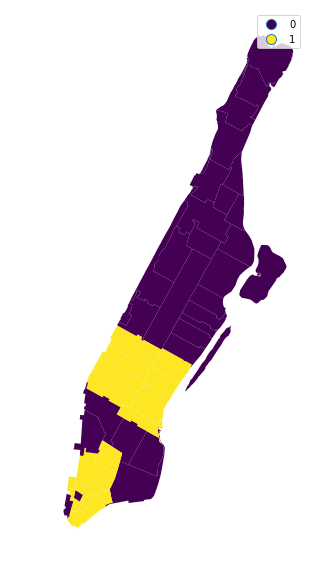

In [17]:
fig = pl.figure(figsize=(10, 10))

#log area
ax = fig.add_subplot(111)

nyc_lodes_zipcode_real[nyc_lodes_zipcode_real.COUNTY == 'New York'].plot(column='top', legend=True, cmap='viridis', ax=ax, categorical=True)

ax.axis('off')
ax.set_aspect('equal')

In [18]:
#rank without manhattan and get top 5
nyc_lodes_zipcode_real['rank_notMN'] = ((nyc_lodes_zipcode_real['COUNTY'] != 'New York').astype(int) \
                    * nyc_lodes_zipcode_real['2015_per_mile']).rank(ascending=False)
nyc_lodes_zipcode_real['top_notMN'] = nyc_lodes_zipcode_real['rank_notMN'].apply(lambda x: 2 if x <= 4 else 0)

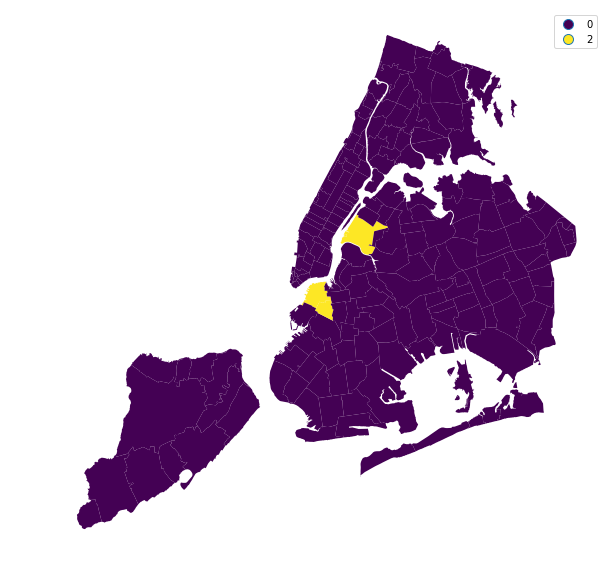

In [19]:
fig = pl.figure(figsize=(10, 10))

#log area
ax = fig.add_subplot(111)

nyc_lodes_zipcode_real.plot(column='top_notMN', legend=True, cmap='viridis', ax=ax, categorical=True)

ax.axis('off')
ax.set_aspect('equal')

In [20]:
#1 for MN 2 for other boroughs
nyc_lodes_zipcode_real['top_all'] = nyc_lodes_zipcode_real['top_notMN'] + nyc_lodes_zipcode_real['top']

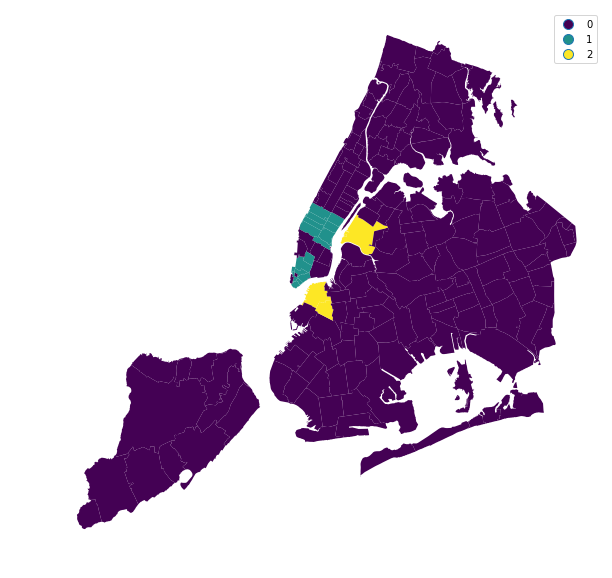

In [21]:
fig = pl.figure(figsize=(10, 10))

#log area
ax = fig.add_subplot(111)

nyc_lodes_zipcode_real.plot(column='top_all', legend=True, cmap='viridis', ax=ax, categorical=True)

ax.axis('off')
ax.set_aspect('equal')

In [22]:
#Get centroids' coordinates
nyc_lodes_zipcode_real['centroid'] = nyc_lodes_zipcode_real.centroid
nyc_lodes_zipcode_real['x'] = nyc_lodes_zipcode_real.centroid.apply(lambda x: x.x)
nyc_lodes_zipcode_real['y'] = nyc_lodes_zipcode_real.centroid.apply(lambda x: x.y)

In [23]:
#Use KMeans to assign ZipCodes to its corresponding CBD
nyc_lodes_cbds = nyc_lodes_zipcode_real.loc[(nyc_lodes_zipcode_real.top_all > 0),:]

kmeans = KMeans(n_clusters=4, random_state=0).fit(
    nyc_lodes_cbds.loc[:,['top_all','x', 'y']].values)
nyc_lodes_cbds['CBDs'] = kmeans.labels_

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


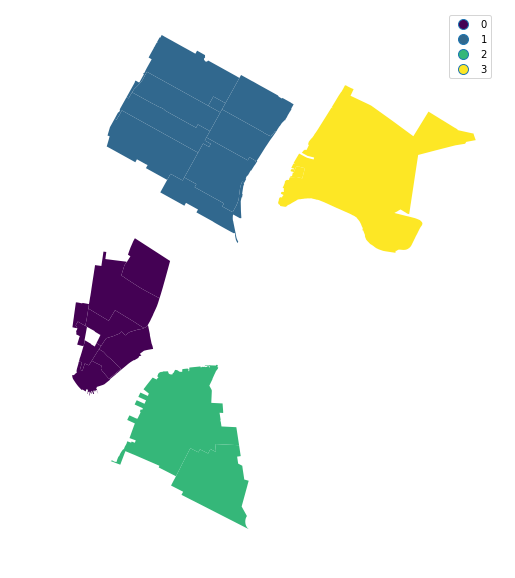

In [24]:
fig = pl.figure(figsize=(10, 10))

#log area
ax = fig.add_subplot(111)

nyc_lodes_cbds.plot(column='CBDs', legend=True, cmap='viridis', ax=ax, categorical=True)

ax.axis('off')
ax.set_aspect('equal')

In [25]:
nyc_lodes_zipcode_final = nyc_lodes_zipcode_real.merge(nyc_lodes_cbds.loc[:,['ZIPCODE', 'CBDs']], on='ZIPCODE', how='left')

In [26]:
nyc_lodes_zipcode_final['CBDs'] = nyc_lodes_zipcode_final.CBDs.fillna(-1)

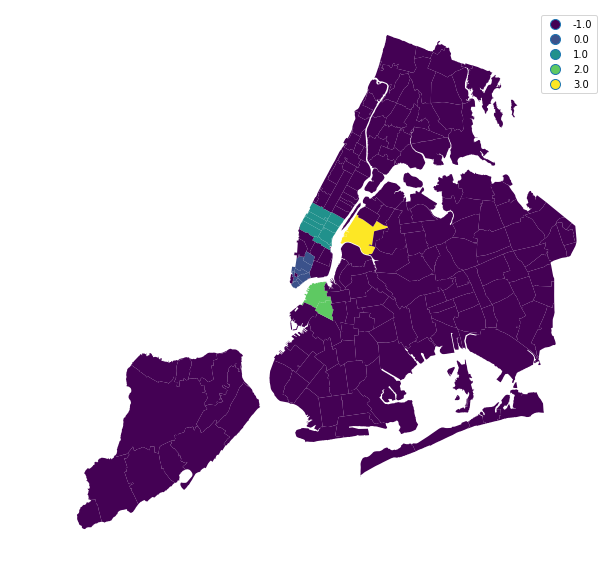

In [27]:
#Final zipcode classification to CBDs
fig = pl.figure(figsize=(10, 10))

#log area
ax = fig.add_subplot(111)

nyc_lodes_zipcode_final.plot(column='CBDs', legend=True, cmap='viridis', ax=ax, categorical=True)

ax.axis('off')
ax.set_aspect('equal')

In [28]:
#Save data
nyc_lodes_zipcode_final = nyc_lodes_zipcode_final.drop('centroid', axis=1)
nyc_lodes_zipcode_final.to_file(puidata + '/nyc_cbds_final.shp')